In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import os, sys
import ruamel.yaml as yaml
from scipy.stats import mannwhitneyu,ks_2samp

plot_dir = "/Users/eric/repos/gohr/misc/ml_plots/neurips/"

if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

In [20]:
class SafeLoaderIgnoreUnknown(yaml.SafeLoader):
    def ignore_unknown(self, node):
        return None 

SafeLoaderIgnoreUnknown.add_constructor(None, SafeLoaderIgnoreUnknown.ignore_unknown)

# Location of rule runs
rule_runs_path = "/Users/eric/repos/gohr/active/outputs/neurips_2023/long_final_runs/"
#rule_runs_path = "/Users/eric/repos/gohr/active/outputs/500_test/"
cluster_runs = [name for name in os.listdir(rule_runs_path) if name!=".DS_Store"]
# runs_to_analyze = ["naive_bd_ad_n2","naive_bd_ad_n4","naive_bd_ad_n6","naive_bd_ad_n8",
#                    "naive_bs_ad_n2","naive_bs_ad_n4","naive_bs_ad_n6","naive_bs_ad_n8",
#                    "naive_bd_as_n2","naive_bd_as_n4","naive_bd_as_n6","naive_bd_as_n8",
#                    "naive_bda_as_n2","naive_bda_as_n4","naive_bda_as_n6","naive_bda_as_n8",
#                    "naive_bs_as_n2","naive_bs_as_n4","naive_bs_as_n6","naive_bs_as_n8",
#                    "naive_bsd_asd_n2","naive_bsd_asd_n4","naive_bsd_asd_n6","naive_bsd_asd_n8"]
runs_to_analyze=["naive_bd_ad_n6","naive_bd_ad_n8"]

# Create lists that will hold dataframes for concatenation
episode_df_list = []
terminal_results_list = []
placeholder_value = np.nan
# DQN
#delta_horizon=150
# REINFORCE
delta_horizon=150
# Loop over the specified rule runs
for cluster_run in cluster_runs:
    cluster_run_path = rule_runs_path+cluster_run+"/"
    for run in runs_to_analyze:
        available_runs = [name for name in os.listdir(cluster_run_path) if name!=".DS_Store"]
        if run not in available_runs:
            continue
        # Form complete run path
        run_path = cluster_run_path+run
            
        # Get the experiments for that run (each one is a set of trials for a particular rule)
        experiments = [name for name in os.listdir(run_path) if name!=".DS_Store"]

        # Loop over the experiments
        for experiment in experiments:
            # Get the cluster id
            cluster_trial = experiment.split("_")[0]
            cluster_process = experiment.split("_")[1]
            cluster_id = cluster_trial+"_"+cluster_process
            # String length may vary
            id_str_length = len(cluster_id)
            # Get the corresponding rule name
            rule_name = experiment[id_str_length+1:]
            # For complete experiment path
            experiment_path = os.path.join(run_path,experiment)
            
            trials = [name for name in os.listdir(experiment_path) if name!=".DS_Store"]

            for trial in trials:
                trial_path = os.path.join(experiment_path,trial)
                # Get parameters
                yaml_path = os.path.join(trial_path,"data.yaml")
                with open(yaml_path, 'r') as param_file:
                    args = yaml.load(param_file, Loader=SafeLoaderIgnoreUnknown)
                    featurization =args["FEATURIZATION"]
                    learner = args["LEARNER"]
                # Import episodic data and process relevant columns
                episodic_data_path = os.path.join(trial_path,"episode_data.csv")
                trial_results = pd.read_csv(episodic_data_path)
                #move_results = pd.read_csv(move_data_path,index_col=0,usecols=['episode','time','reward'])
                
                # Episode processing
                trial_results["rule"]=rule_name
                trial_results["params"]=run
                trial_results["memory"]=int(run[-1])
                trial_results["experiment_id"]=cluster_id
                trial_results["trial"]=trial
                trial_results["featurization"]=featurization
                trial_results["learner"]=learner
                trial_results["ep_error"]=-1*trial_results["reward"]
                trial_results["cumulative_error"] = trial_results.ep_error.cumsum()
                #if trial_results.episode.max()!=1999:
                    #print(trial_results.cluster_id.unique())
                #    continue
                delta_horizon_err_val = trial_results.cumulative_error.iloc[-delta_horizon]
                delta = trial_results.cumulative_error.iloc[-1]-trial_results.cumulative_error.iloc[-delta_horizon]
                #trial_results["100_ep_delta"]=delta

                # DQN
                #converged = (delta/(delta_horizon*9+delta))<0.001
                converged = (delta/(delta_horizon*9+delta))<0.003
                #trial_results["converged"]=converged
                term_entry = trial_results.iloc[-1].to_frame().transpose()
                tce = term_entry.cumulative_error
                term_entry["converged"]=converged
                if converged:
                    adj_error=tce
                else:
                    adj_error=placeholder_value
                term_entry["adj_cumulative_error"]=adj_error
                term_entry["delta"]=delta
                term_entry['horizon_err']=delta_horizon_err_val
                terminal_results_list.append(term_entry)
                test_ser = trial_results.iloc[-1]
                episode_df_list.append(trial_results)
            
# Concatenate everything into one dataframe
episode_results_df = pd.concat(episode_df_list,ignore_index=True)
terminal_results_df = pd.concat(terminal_results_list,ignore_index=True)

In [5]:
terminal_results_df.head()

,episode,reward,rule,params,memory,experiment_id,trial,featurization,learner,ep_error,cumulative_error,converged,adj_cumulative_error,delta,horizon_err
0,14999,0,bottomLeft_then_topRight,naive_bd_ad_n6,6,11066899_114,0,NAIVE_N_BD_AD,REINFORCE,0,1411,True,1411,0,1411
1,14999,0,bottomLeft_then_topRight,naive_bd_ad_n6,6,11066899_114,1,NAIVE_N_BD_AD,REINFORCE,0,1776,True,1776,1,1775
2,14999,0,1_1_shape_4m,naive_bd_ad_n6,6,11066899_9,0,NAIVE_N_BD_AD,REINFORCE,0,21180,False,NaN,7,21173
3,14999,0,1_1_shape_4m,naive_bd_ad_n6,6,11066899_9,1,NAIVE_N_BD_AD,REINFORCE,0,21414,False,NaN,5,21409
4,14999,0,clockwiseTwoFree,naive_bd_ad_n6,6,11066899_75,0,NAIVE_N_BD_AD,REINFORCE,0,3083,True,3083,0,3083


In [21]:
# Rule name replacement
episode_results_df.replace(to_replace={ '1_1_shape_4m':'SM','1_2_shape_4m':'SM2O','1_1_shape_3m_cua':'SM1F',
                                '1_1_color_4m':'CM','1_2_color_4m':'CM2O','1_1_color_3m_cua':'CM1F',
                                'clockwiseZeroStart':'CW','clockwiseTwoFreeAlt':'CWAF','clockwiseTwoFree':'CW2F',
                                'quadrantNearby':'QN','quadrantNearbyTwoFree':'QN2F',
                                'bottomLeft_then_topRight':'BLTR','bottom_then_top':'BT'},inplace=True)
terminal_results_df.replace(to_replace={ '1_1_shape_4m':'SM','1_2_shape_4m':'SM2O','1_1_shape_3m_cua':'SM1F',
                                '1_1_color_4m':'CM','1_2_color_4m':'CM2O','1_1_color_3m_cua':'CM1F',
                                'clockwiseZeroStart':'CW','clockwiseTwoFreeAlt':'CWAF','clockwiseTwoFree':'CW2F',
                                'quadrantNearby':'QN','quadrantNearbyTwoFree':'QN2F',
                                'bottomLeft_then_topRight':'BLTR','bottom_then_top':'BT'},inplace=True)

# Featurization replacement
episode_results_df.replace(to_replace={ 'NAIVE_N_BD_AD':'BD_AD',
                                        'NAIVE_N_BD_AS':'BD_AS',
                                        'NAIVE_N_BS_AD':'BS_AD',
                                        'NAIVE_N_BS_AS':'BS_AS',
                                        'NAIVE_N_BDa_AS':'BDa_AS',
                                        'NAIVE_N_BSD_ASD':'BSD_ASD'
                                        },inplace=True)
terminal_results_df.replace(to_replace={ 'NAIVE_N_BD_AD':'BD_AD',
                                        'NAIVE_N_BD_AS':'BD_AS',
                                        'NAIVE_N_BS_AD':'BS_AD',
                                        'NAIVE_N_BS_AS':'BS_AS',
                                        'NAIVE_N_BDa_AS':'BDa_AS',
                                        'NAIVE_N_BSD_ASD':'BSD_ASD'
                                        },inplace=True)

# complete_rules = ["1_1_shape_4m","1_1_shape_3m_cua","1_2_shape_4m",
#                 "1_1_color_4m","1_1_color_3m_cua","1_2_color_4m", 
#                 "clockwiseZeroStart","clockwiseTwoFreeAlt","clockwiseTwoFree",
#                 "quadrantNearby","quadrantNearbyTwoFree",
#                 "bottomLeft_then_topRight","bottom_then_top"]
complete_rules = ["SM","SM1F","SM2O","CM","CM1F","CM2O","QN","QN2F","BLTR","BT","CW","CWAF","CW2F"]
base_rules = ["SM","CM","QN","BLTR","CW"]
steps = [2,4,6,8]

In [22]:
# DQN array plotting
complete_list = episode_results_df.rule.unique()
# rules_list = [#{"name":"all_rules","rules":complete_list,"y":[0,4000]},
#                 #{"name":"quick_test","rules":["1_1_shape_4m","1_2_shape_4m"],"y":[0,2500]}
#                 #{"name":"base_rules","rules":["1_1_shape_4m","clockwiseZeroStart","quadrantNearby","bottomLeft_then_topRight"],"y":[0,4000]},
#                 {"name":"shape_rules","rules":["1_1_shape_4m","1_1_shape_3m_cua","1_2_shape_4m"],"y":[0,2500]},
#                 {"name":"color_rules","rules":["1_1_color_4m","1_1_color_3m_cua","1_2_color_4m"],"y":[0,2500]}, 
#                 {"name":"clockwise_rules","rules":["clockwiseZeroStart","clockwiseTwoFreeAlt","clockwiseTwoFree"],"y":[0,4000]},
#                 {"name":"quadrant_rules","rules":["quadrantNearby","quadrantNearbyTwoFree"],"y":[0,400]},
#                 {"name":"bottom_top_rules","rules":["bottomLeft_then_topRight","bottom_then_top"],"y":[0,1500]}
#                 ]
rules_list = [#{"name":"all_rules","rules":complete_list,"y":[0,4000]},
                #{"name":"quick_test","rules":["1_1_shape_4m","1_2_shape_4m"],"y":[0,2500]}
                #{"name":"base_rules","rules":["1_1_shape_4m","clockwiseZeroStart","quadrantNearby","bottomLeft_then_topRight"],"y":[0,4000]},
                {"name":"shape_rules","rules":["SM","SM1F","SM2O"],"y":[0,4000]},
                {"name":"color_rules","rules":["CM","CM1F","CM2O"],"y":[0,4000]}, 
                {"name":"clockwise_rules","rules":["CW","CWAF","CW2F"],"y":[0,4000]},
                {"name":"quadrant_rules","rules":["QN","QN2F"],"y":[0,400]},
                {"name":"bottom_top_rules","rules":["BLTR","BT"],"y":[0,1500]}
                ]

steps = terminal_results_df.memory.unique()
gs = GridSpec(nrows = len(rules_list),ncols=len(steps))
#feats = ["NAIVE_N_BD_AD","NAIVE_N_BS_AD","NAIVE_N_BD_AS","NAIVE_N_BDa_AS","NAIVE_N_BS_AS", "NAIVE_N_BSD_ASD"]
feats = ["BD_AD","BS_AD","BD_AS","BDa_AS","BS_AS", "BSD_ASD"]

In [13]:
# REINFORCE array plotting
complete_list = episode_results_df.rule.unique()
rules_list = [#{"name":"all_rules","rules":complete_list,"y":[0,4000]},
                #{"name":"quick_test","rules":["1_1_shape_4m","1_2_shape_4m"],"y":[0,2500]}
                #{"name":"base_rules","rules":["1_1_shape_4m","clockwiseZeroStart","quadrantNearby","bottomLeft_then_topRight"],"y":[0,4000]},
                {"name":"shape_rules","rules":["SM","SM1F","SM2O"],"y":[0,30000]},
                {"name":"color_rules","rules":["CM","CM1F","CM2O"],"y":[0,30000]}, 
                {"name":"clockwise_rules","rules":["CW","CWAF","CW2F"],"y":[0,30000]},
                {"name":"quadrant_rules","rules":["QN","QN2F"],"y":[0,400]},
                {"name":"bottom_top_rules","rules":["BLTR","BT"],"y":[0,5000]}
                ]

steps = terminal_results_df.memory.unique()
print(steps)
gs = GridSpec(nrows = len(rules_list),ncols=len(steps))
#feats = ["NAIVE_N_BD_AD","NAIVE_N_BS_AD","NAIVE_N_BD_AS","NAIVE_N_BDa_AS","NAIVE_N_BS_AS", "NAIVE_N_BSD_ASD"]
feats = ["BD_AD","BS_AD","BD_AS","BDa_AS","BS_AS", "BSD_ASD"]

[8 6]


In [23]:
# Array plotting
reduced_results = episode_results_df.query("episode%20==0 & learner=='DQN'")
reduced_results.head()

,episode,reward,rule,params,memory,experiment_id,trial,featurization,learner,ep_error,cumulative_error
2600000,0,-22,BLTR,naive_bd_ad_n6,6,11066957_113,0,BD_AD,DQN,22,22
2600020,20,-7,BLTR,naive_bd_ad_n6,6,11066957_113,0,BD_AD,DQN,7,260
2600040,40,-1,BLTR,naive_bd_ad_n6,6,11066957_113,0,BD_AD,DQN,1,285
2600060,60,-2,BLTR,naive_bd_ad_n6,6,11066957_113,0,BD_AD,DQN,2,305
2600080,80,0,BLTR,naive_bd_ad_n6,6,11066957_113,0,BD_AD,DQN,0,315


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


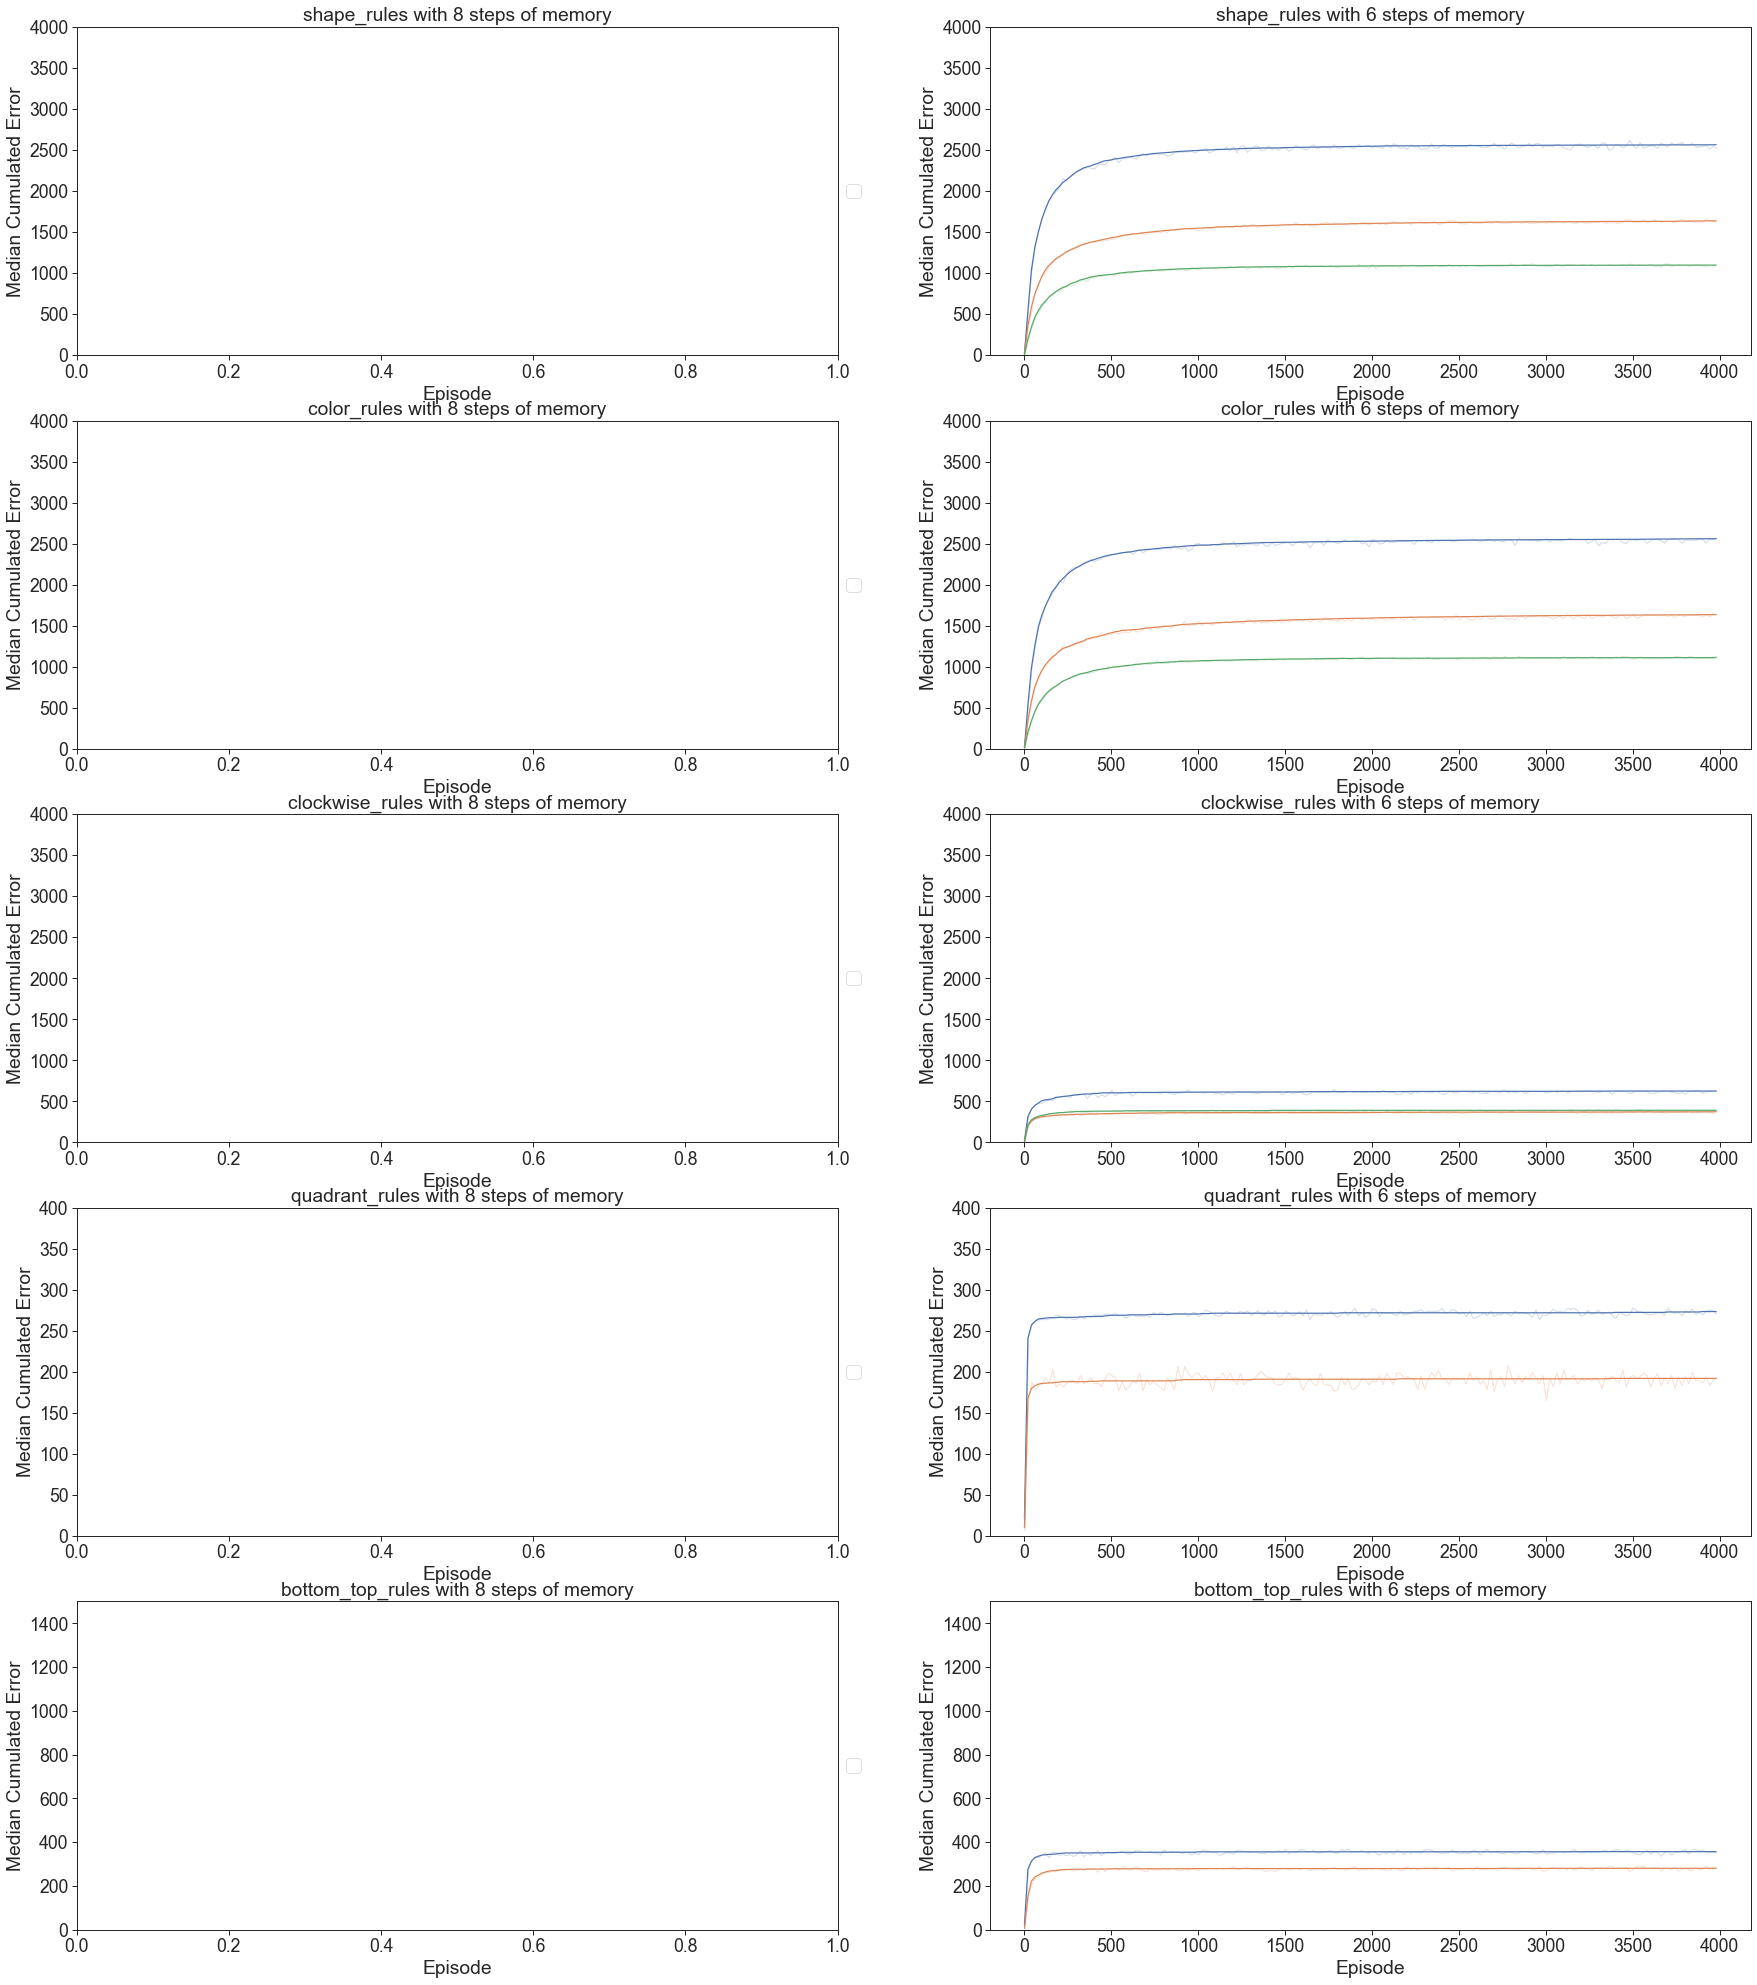

In [24]:
# Create a figure grid for all results
fig = plt.figure(figsize=(30,35))
for idx,step in enumerate(steps):
    #results_df = episode_results_df[episode_results_df.memory==step]
    results_df = reduced_results[reduced_results.memory==step]
    for i in range(len(rules_list)):
        sub_dict = rules_list[i]
        sub_list = sub_dict["rules"]
        name = sub_dict["name"]
        ax = fig.add_subplot(gs[i,idx])
        if not(step==8):
            ax=sns.lineplot(data=results_df.query("rule in @sub_list"),y="cumulative_error",x="episode",errorbar=("ci",95),n_boot=1, estimator=np.median,hue="rule",hue_order=sub_list,style="featurization",style_order=feats,legend=False)
        else:
            ax=sns.lineplot(data=results_df.query("rule in @sub_list"),y="cumulative_error",x="episode",errorbar=("ci",95),n_boot=1, estimator=np.median,hue="rule",hue_order=sub_list,style="featurization",style_order=feats)
            #errorbar=("ci",95),n_boot=1
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_title(name+" with {} steps of memory".format(str(step)))
        ax.set_ylim(np.array(sub_dict["y"]))
        ax.set_ylabel("Median Cumulated Error")
        ax.set_xlabel("Episode")
#plt.savefig(plot_dir+'dqn_500_500_ml_6_ways.pdf',bbox_inches='tight',facecolor='w')
#plt.savefig(plot_dir+'ml_6_ways_base_rules.pdf',bbox_inches='tight',facecolor='w')

In [76]:
display(terminal_results_df.query("memory==6 & featurization=='BD_AD' & rule=='CW2F'"))

,episode,reward,rule,params,memory,experiment_id,trial,featurization,learner,ep_error,cumulative_error,converged,adj_cumulative_error,delta,horizon_err
534,2499,0,CW2F,naive_bd_ad_n6,6,11064370_715,0,BD_AD,DQN,0,342,True,342.0,0,342
535,2499,0,CW2F,naive_bd_ad_n6,6,11064370_715,1,BD_AD,DQN,0,382,True,382.0,0,382
536,2499,0,CW2F,naive_bd_ad_n6,6,11064370_715,4,BD_AD,DQN,0,354,True,354.0,0,354
537,2499,0,CW2F,naive_bd_ad_n6,6,11064370_715,3,BD_AD,DQN,0,396,True,396.0,0,396
538,2499,0,CW2F,naive_bd_ad_n6,6,11064370_715,2,BD_AD,DQN,0,405,True,405.0,0,405
609,2499,0,CW2F,naive_bd_ad_n6,6,11064370_714,0,BD_AD,DQN,0,395,True,395.0,0,395
610,2499,0,CW2F,naive_bd_ad_n6,6,11064370_714,1,BD_AD,DQN,0,421,True,421.0,0,421
611,2499,0,CW2F,naive_bd_ad_n6,6,11064370_714,4,BD_AD,DQN,0,371,True,371.0,0,371
612,2499,0,CW2F,naive_bd_ad_n6,6,11064370_714,3,BD_AD,DQN,0,404,True,404.0,0,404
613,2499,0,CW2F,naive_bd_ad_n6,6,11064370_714,2,BD_AD,DQN,0,388,True,388.0,0,388


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


['SM', 'SM1F', 'SM2O', 'CM', 'CM1F', 'CM2O', 'QN', 'QN2F', 'BLTR', 'BT', 'CW', 'CWAF', 'CW2F']


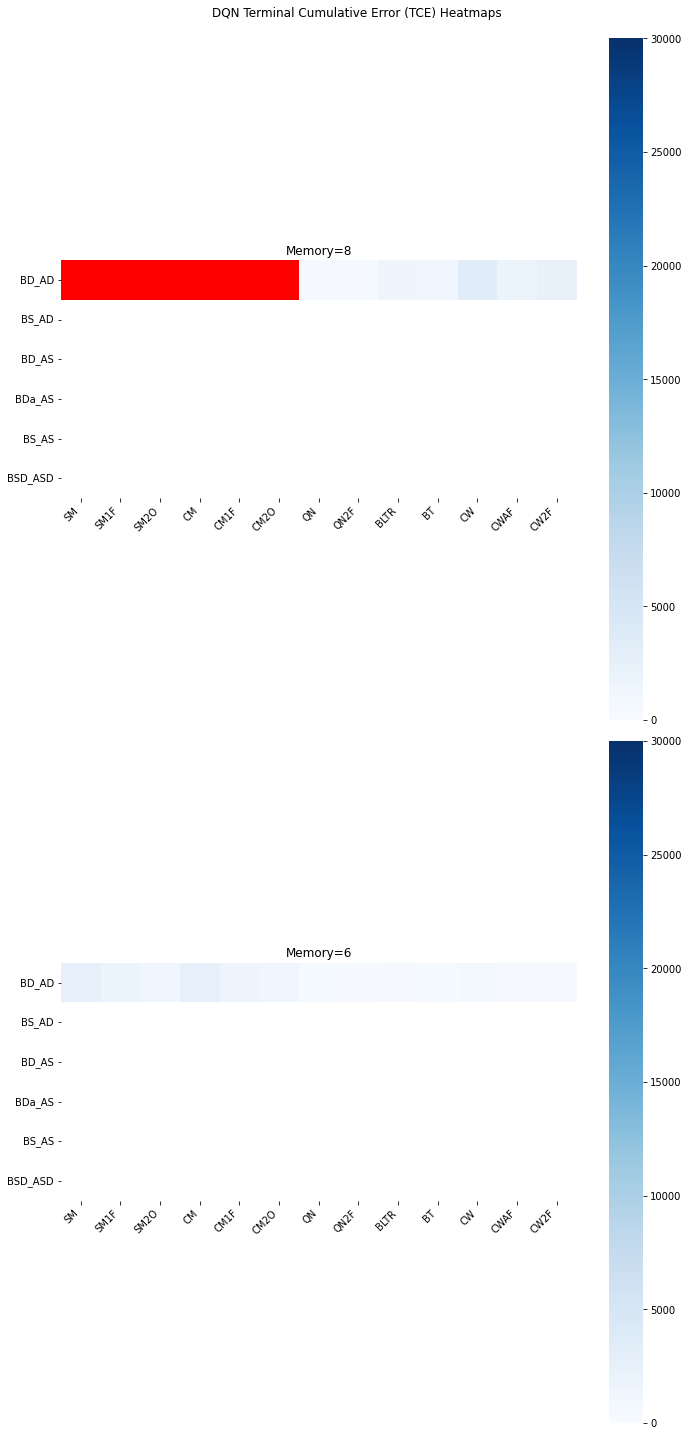

In [16]:
chosen_rules = complete_rules
num_feats = len(feats)
num_rules = len(chosen_rules)
num_steps = len(steps)
tce_heatmap = np.empty((num_steps,num_feats,num_rules))
for i in range(num_feats):
    curr_feat = feats[i]
    for j in range(num_rules):
        curr_rule = chosen_rules[j]
        for k in range(num_steps):
            curr_step = steps[k]
            curr_df = terminal_results_df.query("rule==@curr_rule & featurization==@curr_feat & memory==@curr_step").copy().fillna(50000)
            errors = curr_df.adj_cumulative_error.to_numpy(copy=True)
            med_err = np.median(errors)
            tce_heatmap[k][i][j]=med_err
print(chosen_rules)

fig = plt.figure(figsize=(10,20))
gs = GridSpec(nrows = len(steps),ncols=1)
green = sns.light_palette("seagreen", reverse=True, as_cmap=True)
blue = sns.color_palette("Blues",as_cmap=True)
blue.set_over('red')
for i,step in enumerate(steps):
    ax = fig.add_subplot(gs[i,0])
    sns.heatmap(ax=ax,data=tce_heatmap[i],cmap=blue,vmin=0,vmax=30000,yticklabels=feats,xticklabels=chosen_rules,square=True)#,annot=True,yticklabels=sorted_rules_labeled,linewidth=.5,vmin=0,vmax=alpha/comparisons,cmap=green,cbar=False,square=True,fmt='.5f')
    ax.set_title("Memory={}".format(str(step)))
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 45,horizontalalignment="right")
fig.suptitle('DQN Terminal Cumulative Error (TCE) Heatmaps',x=0.5,y=.995,ha='center')
fig.tight_layout()
#plt.savefig(plot_dir+'dqn_500_500_100ep.pdf',bbox_inches='tight',facecolor='w')

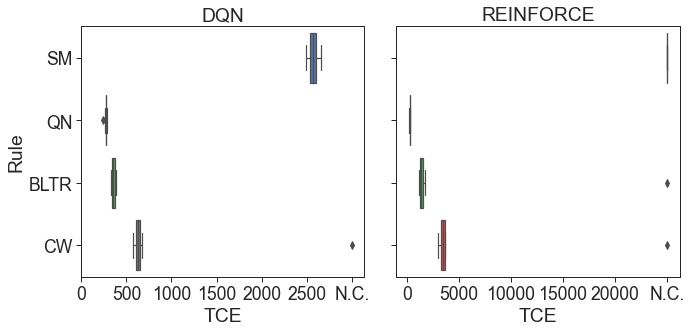

In [17]:
# Final results plotting
sns.set(font_scale=2)
sns.set_style('ticks')
sns.set_context('paper',font_scale=2)
chosen_rules = [rule for rule in base_rules if rule not in ['CM','CM1F','CM2O']]
final_df = terminal_results_df.copy()
max_val_reinforce = final_df.query("learner=='REINFORCE'").adj_cumulative_error.max()
max_val_dqn = final_df.query("learner=='DQN'").adj_cumulative_error.max()

fig, (ax1,ax2) = plt.subplots(figsize=(10,5),ncols=2,sharey=True)

step = 500
tick_max = int((np.ceil(max_val_dqn/step)+1)*step)
ticks = [*range(0,tick_max,step)]
str_ticks = [str(i) for i in ticks]
str_ticks[-1]='N.C.'
sns.boxplot(ax=ax1,data=final_df.query("learner=='DQN'").fillna(ticks[-1]),x='adj_cumulative_error',y='rule',order=chosen_rules)
ax1.set_xticks(ticks)
ax1.set_xticklabels(str_ticks)
ax1.set_xlabel("TCE")
ax1.set_ylabel("Rule")
ax1.set_title("DQN")

step=5000
tick_max = int((np.ceil(max_val_reinforce/step)+1)*step)
ticks = [*range(0,tick_max,step)]
str_ticks = [str(i) for i in ticks]
str_ticks[-1]='N.C.'
sns.boxplot(ax=ax2,data=final_df.query("learner=='REINFORCE'").fillna(ticks[-1]),x='adj_cumulative_error',y='rule',order=chosen_rules)
ax2.set_xticks(ticks)
ax2.set_xticklabels(str_ticks)
ax2.set_xlabel("TCE")
ax2.set_ylabel("")
ax2.set_title("REINFORCE")
fig.tight_layout()
plt.savefig(plot_dir+"rl_base_rules.pdf",bbox_inches='tight',facecolor='w')

In [80]:
# Base rules comparison
cur_rules = base_rules

final_nonan = final_df.copy().fillna(50000)

for alg in ['DQN','REINFORCE']:
    print(alg)
    mw_heatmap = np.empty((len(cur_rules),len(cur_rules)))
    mw_heatmap[:]=np.nan
    for idx,i in enumerate(cur_rules):
        for idy,j in enumerate(cur_rules):
            a = final_nonan.query("rule==@i & learner==@alg").adj_cumulative_error.to_numpy(dtype=int)
            #print(a)
            b = final_nonan.query("rule==@j & learner==@alg").adj_cumulative_error.to_numpy(dtype=int)
            #print(b)
            if np.isnan(mw_heatmap[idy,idx]):
                #u,p1 = mannwhitneyu(x=a,y=b,alternative="less",method="asymptotic")
                u,p1 = mannwhitneyu(x=a,y=b,method="asymptotic")
                #mw_heatmap[idx,idy]=np.around(p1,decimals=4)
                mw_heatmap[idx,idy]=p1
    print(mw_heatmap)

DQN
[[1.00000000e+00 9.24562144e-01 6.72882543e-08 6.74784974e-08
  6.75737941e-08]
 [           nan 1.00000000e+00 6.75737941e-08 6.77647383e-08
  6.78603862e-08]
 [           nan            nan 1.00000000e+00 6.73833175e-08
  6.74784974e-08]
 [           nan            nan            nan 1.00000000e+00
  6.76692077e-08]
 [           nan            nan            nan            nan
  1.00000000e+00]]
REINFORCE
[[1.00000000e+00 8.15967499e-02 2.95503155e-08 2.95503155e-08
  9.01594813e-07]
 [           nan 1.00000000e+00 1.12665704e-08 1.12665704e-08
  1.78718870e-07]
 [           nan            nan 1.00000000e+00 6.79561513e-08
  6.78603862e-08]
 [           nan            nan            nan 1.00000000e+00
  6.78603862e-08]
 [           nan            nan            nan            nan
  1.00000000e+00]]


In [82]:
# Generality comparisons
gen_comparisons = [['SM','SM1F','SM2O'],
                   ['CM','CM1F','CM2O'],
                   ['QN','QN2F'],
                   ['BLTR','BT'],
                   ['CW','CWAF','CW2F']]
for alg in ['DQN','REINFORCE']:
    print(alg)
    for rule_set in gen_comparisons:
        print(rule_set)
        if len(rule_set)==3:
            a = final_df.query("rule==@rule_set[0] & learner==@alg").adj_cumulative_error.to_numpy(dtype=int)
            b = final_df.query("rule==@rule_set[1]  & learner==@alg").adj_cumulative_error.to_numpy(dtype=int)
            c = final_df.query("rule==@rule_set[2]  & learner==@alg").adj_cumulative_error.to_numpy(dtype=int)
            print(a.size,b.size,c.size)
            print("Comparing {} to {}".format(rule_set[1],rule_set[0]))
            u,p1 = mannwhitneyu(x=b,y=a,alternative="greater",method="asymptotic")
            print(p1)
            print("Comparing {} to {}".format(rule_set[2],rule_set[0]))
            u,p1 = mannwhitneyu(x=c,y=a,alternative="greater",method="asymptotic")
            print(p1)
        else:
            a = final_df.query("rule==@rule_set[0]  & learner==@alg").adj_cumulative_error.to_numpy(dtype=int)
            b = final_df.query("rule==@rule_set[1]  & learner==@alg").adj_cumulative_error.to_numpy(dtype=int)
            print(a.size,b.size)
            print("Comparing {} to {}".format(rule_set[1],rule_set[0]))
            u,p1 = mannwhitneyu(x=b,y=a,alternative="greater",method="asymptotic")
            print(p1)
        print()
    print()

DQN
['SM', 'SM1F', 'SM2O']
20 20 20
Comparing SM1F to SM
0.999997406045305
Comparing SM2O to SM
0.9999929517942086

['CM', 'CM1F', 'CM2O']
20 20 20
Comparing CM1F to CM
0.9999999712398586
Comparing CM2O to CM
0.9999999708684908

['QN', 'QN2F']
20 20
Comparing QN2F to QN
0.999999971075318

['BLTR', 'BT']
20 20
Comparing BT to BLTR
0.9999999709927411

['CW', 'CWAF', 'CW2F']
20 20 20
Comparing CWAF to CW
0.9999999710340551
Comparing CW2F to CW
0.9999999708684908


REINFORCE
['SM', 'SM1F', 'SM2O']
20 20 20
Comparing SM1F to SM
0.7758761465000891
Comparing SM2O to SM
0.5749836501725609

['CM', 'CM1F', 'CM2O']
20 20 20
Comparing CM1F to CM
0.02877130484912125
Comparing CM2O to CM
0.0003842606082691333

['QN', 'QN2F']
20 20
Comparing QN2F to QN
0.9999999710340551

['BLTR', 'BT']
20 20
Comparing BT to BLTR
0.9202374578060148

['CW', 'CWAF', 'CW2F']
20 20 20
Comparing CWAF to CW
0.9999937766901585
Comparing CW2F to CW
0.9999898055504925




377


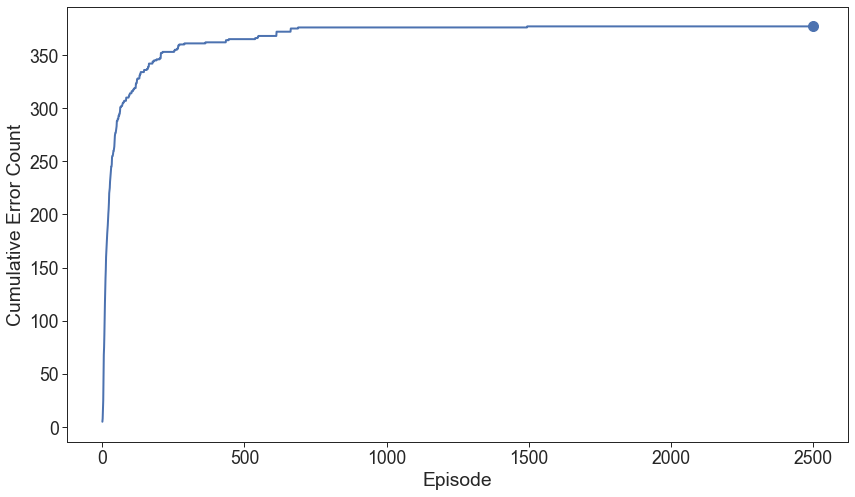

In [109]:
# Sample ML plot
episode_results_df.head()
sample=episode_results_df.query("experiment_id=='11066898_79' & trial=='0'").copy()
sample.head()

fig,ax = plt.subplots(figsize=(14,8))
sns.set_context('paper',font_scale=2)
sns.set_style('ticks')
sns.lineplot(ax=ax,data=sample,x='episode',y='cumulative_error',linewidth=2)
ax.set_xlabel('Episode')
ax.set_ylabel('Cumulative Error Count')
max_val = sample.iloc[-1].cumulative_error
print(sample.iloc[-1].cumulative_error)
step = 50
tick_max = int((np.ceil(max_val/step)+1)*step)
ticks = [*range(0,tick_max,step)]
str_ticks = [str(i) for i in ticks]
ax.set_yticks(ticks)
ax.set_yticklabels(str_ticks)
plt.plot(sample.iloc[-1].episode,max_val,'bo',markersize=10)
fig.savefig(plot_dir+'sample_ml_player.pdf',bbox_inches='tight',facecolor='w')
